### CBLOF Improve kMeans-Anomaly Detection 
[Git Issue 1085](https://github.ibm.com/wiotp/monitoring-dashboard/issues/1085)

**Goal** 
To make anomaly detection better using #clusters and thresholding <br/>
* Use heuristics (Elbow method, silouetter score, and calinski harabasz ) to determine a `good` value for # centroids
* Determine thresholding for anomaly score
* Can we store and reuse these values - use first half of data to find suitable values and second half to analyze effectiveness

**Progress**
* Updated KMeansAnomalyScore module to accept num_clusters as parameter *(local iofunctions changes)*
* Analyzed the effects of changing number of clusters for the same dataset
* Peformed the same analysis on 4 datasets
* Analyzed if the same threshold works data sampled in different time periods
* Updated KMeansAnomalyScore module to accept contamination as parameter *(local iofunctions changes)*

**Future work**
* Can we learn contamination?

#### I. STEPS TO ANALYZE CLUSTERING <br>

1. Select sample data<br>
2. Perform **elbow method**, **silhouette scoring**, and **calinski harabasz scoring** <br>
3. Implement max voting or avergae for determining the num of clusters (Currently using max of all cluster recoomendations) <br>
4. Analyze if num of clusters derived from above method yields better results than the hardset value of k=40<br>

#### II. STEPS TO ANALYZE THRESHOLD AFTER STANDARDIZING DATA <br>

1. Select sample data<br>
2. Set standardize_data=True
3. Get the threshold after scaling data (using first half of data)<br>
4. Use the threshold on the second half of the data and analyze detection quality 

#### CONCLUSIONS and DISCUSSION <br>

---
I.a
* Picking the right threshold takes precendence over choosing the number of clusters
* Can contamination be pre-determined for a time period (by people with domain knowledge)?
* Better contamination will lead to a better threshold and anomaly detection <br>
  **contamination** : float in (0., 0.5), optional (default=0.1) <br> the proportion of outliers in the data set. Used when fitting to define the threshold on the decision function. <br>
---
I.b
* Using different number of clusters didn't show any drastic differences in the std, or range of the anomalies scores <br>
  **Reasoning** <br>
* In CBOLF Outliers scores are computed based on their distance to the closest large cluster center.
* Our clusters score~0.5 on silouetter analysis => clusters are not well-formed => for a datapoint, distance from a large cluster center remains similar when varying # clusters
* Changing the number of clusters doesn't yeild significant difference
---
II.a
* "Learning" thresholding for anomaly scores only works if anomalies are uniformly distributed in data
* For sensor data, this might imply learning/applying sensor sensitivity in collecting data
* Standardizing the data doesn't gaurantee a uniform distribution of threshold 
---

#### OBSERVATION <br>

*Data 1* : **Azure Temperature Data**
* anomaly scores have std=1.03, and range [0.009, 0.75]
* Using recommended threshold has false positives
* Different threshold recommendatiosn by CBLOF on different runs
* True detection rate remains the same with different number of clusters
* Works well when setting a higher than recommended threshold <br/>
 *After standardizing*
* std=0.71, range=[0,  5.07]


*Data 2* : **Amrstark Good Data**
* anomaly scores have std=0.02, and are between [0.02, 0.2]
* 19 clusters recommended by elbow method
* A lot of false positives with recommended threshold
* the low range and std of anomaly scores can indicate no anomaly -> based on which we can recommend a higher threshold?
* not much change in std and range with 19 clusters or 40 clusters

*Data 3* : **Amrstark Bad Data**
* anomaly scores have std=0.11, and range [0.02, 0.67]
* 18 clusters recommended by elbow method, with recommended threhsold=0.39
* similar results with 40 clusters
* works well with the recommended thresholds - detects the anomalous motor vibrations

*Data 4* : **Synthetic Data from Anomaly Data Generator**
* anomaly scores have std=1838.18, and range [0.72, 22020.5]
* elbow methos fails for this
* calinski harabasz recommends 30 clusters
* recommended threshold of 31 is worse than chosing a bigger threshold (like 222, which is the mean)
* similar results with 40 clusters

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt

from src.comparingmodels import (utils, data, models)

import logging
from iotfunctions.enginelog import EngineLogging
EngineLogging.configure_console_logging(logging.INFO)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/iotfunctions/bif.py:1884: UserWarning: IoTCalcSettings is deprecated. Use entity type constants instead of a metadata provider to set entity type properties
  warnings.warn(('IoTCalcSettings is deprecated. Use entity type constants'


**SELECT DATA TO ANALYSE** <br>
uncomment the data source you want to use

In [2]:
#Select (by uncommenting) a data source
datapath = '../data/AzureAnomalysample.csv'; datakey='Temperature'
#datapath = '../data/Armstark04714B6046D5.csv'; datakey='ArmstarkGoodData'
#datapath='../data/Armstark04714B604101.csv'; datakey='ArmstarkBadData'
#datapath = '../data/Anomaly_Sample_data.csv'; datakey='SampleAnomalyData'

**SET Standardizing data** <br>
set to True, or Flase

In [3]:
standardize_data = True

**1. Data Processing**

In [4]:
#-------------------------------DATA 1-------------------------------#
if datakey is "Temperature":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='timestamp')
    dp.add_entity('MyRoom')
    dp.add_derived_column('Temperature', 'value', 20)
    dp.process_data()
    df = dp.get_data()
    df = df.drop(columns=['value'])
    #column we want to analyze
    columnname='Temperature'
    entity='MyRoom'
    
#-------------------------------DATA 2-------------------------------#
if datakey is "ArmstarkGoodData":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='RCV_TIMESTAMP_UTC')
    dp.change_column_name('entity', 'DEVICE_ID')
    dp.change_column_name('timestamp', 'RCV_TIMESTAMP_UTC')
    dp.process_data()
    df = dp.get_data()

    #filter data to specific needs
    listAttr = ['timestamp', 'entity', 'vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
                'accel_power_2', 'accel_power_3', 'accel_power_4']
    utils.l2norm(df, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
    utils.l2norm(df, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
    utils.l2norm(df, 'accel_speed', 'ACCEL_SPEED')
    utils.unrollAccel(df)
    df = dp.filter_data(listAttr)

    #colum we want to analyze
    columnname = 'vibrations'
    entity='04714B6046D5'
    
#-------------------------------DATA 3-------------------------------#
if datakey is "ArmstarkBadData":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='RCV_TIMESTAMP_UTC')
    dp.change_column_name('entity', 'DEVICE_ID')
    dp.change_column_name('timestamp', 'RCV_TIMESTAMP_UTC')
    dp.process_data()
    df = dp.get_data()

    #filter data to specific needs
    listAttr = ['timestamp', 'entity', 'vibrations', 'rms', 'accel_speed', 'accel_power_0', 'accel_power_1',
                'accel_power_2', 'accel_power_3', 'accel_power_4']
    utils.l2norm(df, 'vibrations', 'VIBRATIONS_XAXIS', 'VIBRATIONS_YAXIS', 'VIBRATIONS_ZAXIS')
    utils.l2norm(df, 'rms', 'RMS_X', 'RMS_Y', 'RMS_Z')
    utils.l2norm(df, 'accel_speed', 'ACCEL_SPEED')
    utils.unrollAccel(df)
    df = dp.filter_data(listAttr)

    #colum we want to analyze
    columnname = 'vibrations'
    entity='04714B604101'
    
#-------------------------------DATA 4-------------------------------#
if datakey is "SampleAnomalyData":
    dp = data.DataProcessor(filepath=datapath, timestampcolumn='EVT_TIMESTAMP')
    dp.change_column_name('entity', 'DEVICEID')
    dp.change_column_name('timestamp', 'EVT_TIMESTAMP')
    dp.drop_columns(columns=['LOGICALINTERFACE_ID', 'EVENTTYPE', 'FORMAT', 'TURBINE_ID'])
    dp.process_data()
    df = dp.get_data()
    #colum we want to analyze
    columnname = 'TEMPERATURE' #PRESSURE
    entity='A101'

#Standardizing
df_val = df[int(df.shape[0]/2)+1:]
df = df[:int(df.shape[0]/2)]
if standardize_data:
    df = dp.standard_scaler(df, columnname)
    df_val = dp.scaler_transform(df_val, columnname)

X = np.array(df[columnname])
try:
    X.shape[1]
except:
    X = X.reshape(-1, 1)
    
df.head()

Temperature
entity timestamp                       
MyRoom 2017-10-09 20:32:00    -0.895267
       2017-10-09 20:33:00    -0.895267
       2017-10-09 20:34:00    -0.895267
       2017-10-09 20:35:00    -0.895267
       2017-10-09 20:36:00    -0.895267

**2. Elbow Method**

/Applications/anaconda3/envs/ml_mmfunctions/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


elbow value 21
elbow score 6.158277621850221


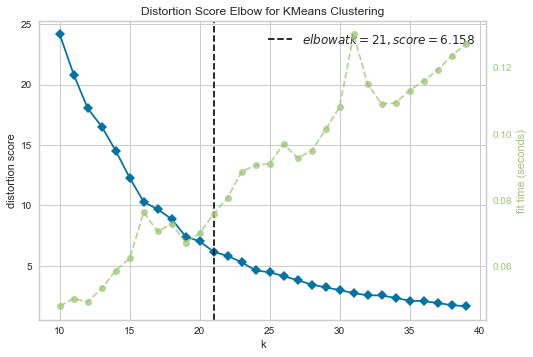

In [10]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
#timings=False to hid the green line
visualizer = KElbowVisualizer(KMeans(), k=(10, 40))

visualizer.fit(X)  # Fit the data to the visualizer

print(f'elbow value {visualizer.elbow_value_}')
print(f'elbow score {visualizer.elbow_score_}')
visualizer.show()  # Finalize and render the figure

**3. Silouette Scoring**

elbow value 17
elbow score 0.5798562374521725


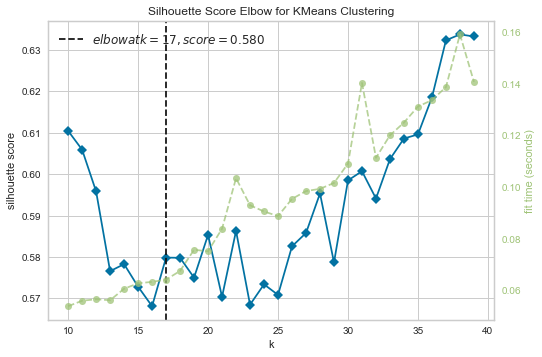

In [11]:
visualizer = KElbowVisualizer(KMeans(), k=(10,40), metric='silhouette')

visualizer.fit(X)  # Fit the data to the visualizer

print(f'elbow value {visualizer.elbow_value_}')
print(f'elbow score {visualizer.elbow_score_}')
visualizer.show()  # Finalize and render the figure

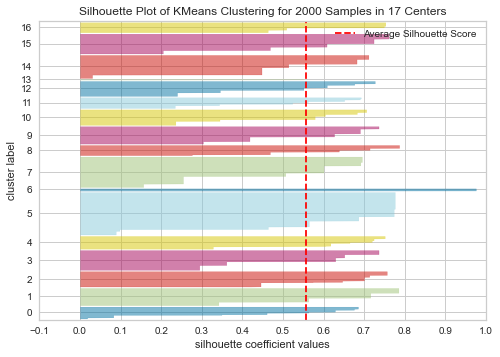

In [12]:
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
model = KMeans(17, random_state=50)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**4. Calinski Harabasz**

elbow value 15
elbow score 23563.30690077523


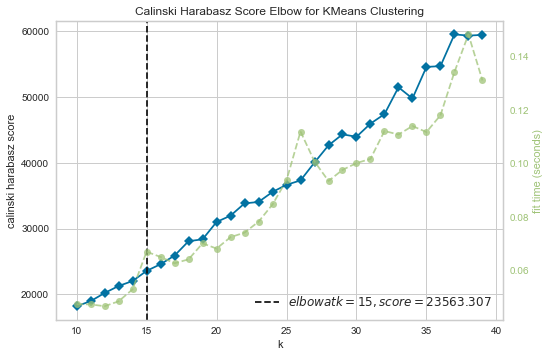

In [13]:
visualizer = KElbowVisualizer(KMeans(), k=(10,40), metric='calinski_harabasz')

visualizer.fit(X)  # Fit the data to the visualizer

print(f'elbow value {visualizer.elbow_value_}')
print(f'elbow score {visualizer.elbow_score_}')
visualizer.show()  # Finalize and render the figure

**Analyze on anomaly detection model (Running kmeans anomaly model)** <br/>
on first half of data

In [5]:
em = models.ExistingModels(columnname=columnname)

#add number of cluster as option
df_anomaly = em.run_kmeans(df, nclusters=40)
df_anomaly.describe()

2020-08-20T09:37:25.039 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-08-20T09:37:25.039 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-08-20T09:37:26.418 INFO src.anomalymodels.anomaly.execute For entity MyRoom CBLOF threshold: 0.44871698045748104


,Temperature,KmeansAnomalyScore
count,2.000000e+03,2000.000000
mean,8.242296e-16,0.410575
std,1.000250e+00,0.614697
min,-3.010018e+00,0.001550
25%,-8.512094e-01,0.225557
50%,-1.462923e-01,0.273835
75%,6.907967e-01,0.340422
max,3.158007e+00,5.494075


kmeans anomaly threshold: 0.43


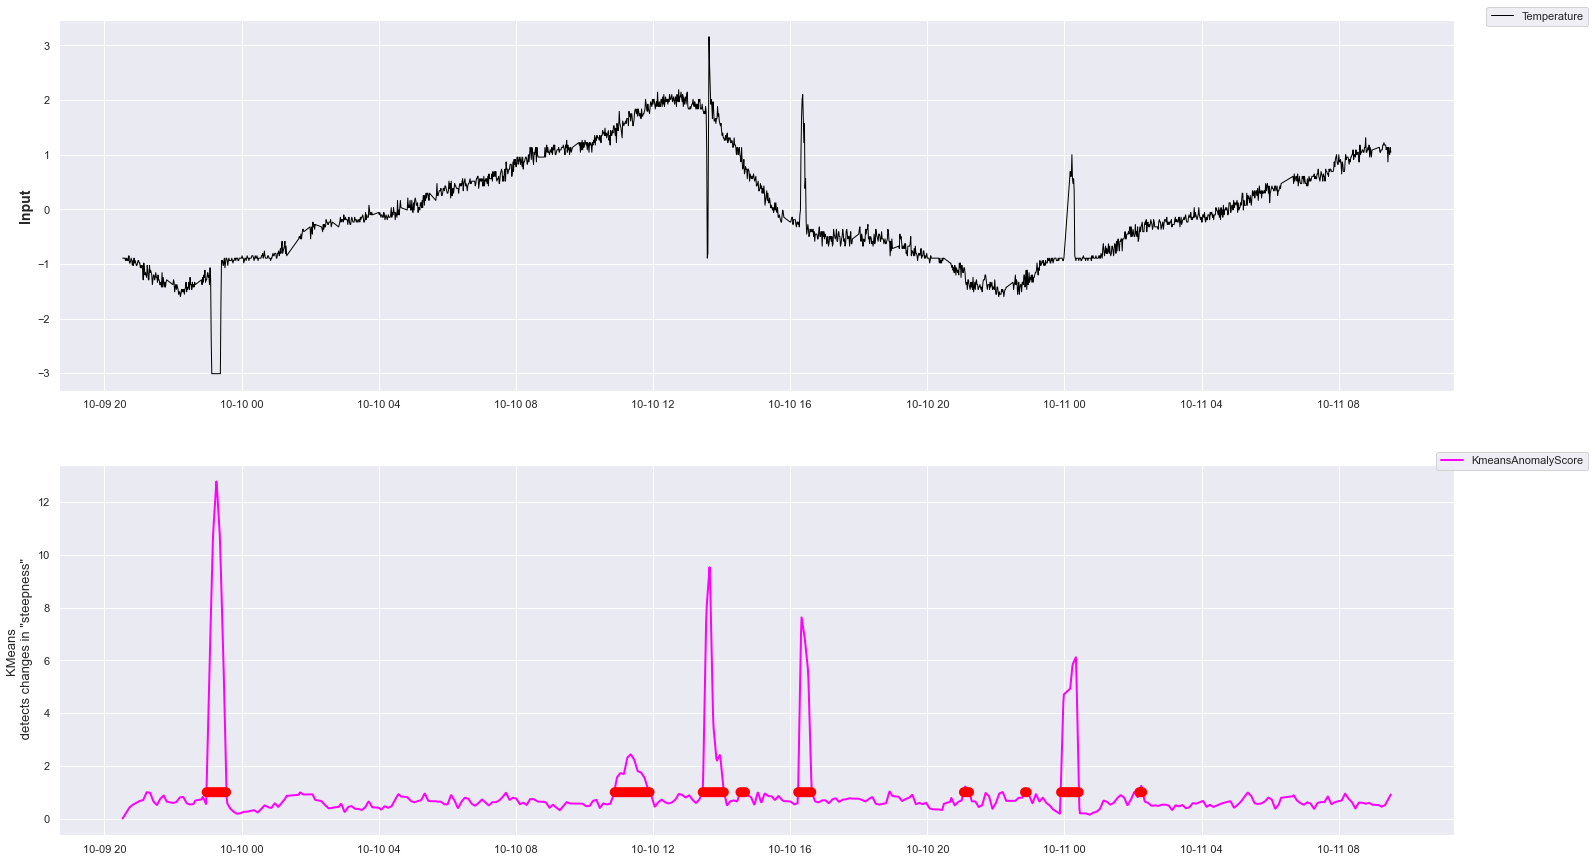

In [6]:
# Simplify dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)
df_plot = df_anomaly.loc[[entity]]
df_plot.reset_index(level=[0], inplace=True)
em.visualize_kmeans(df_plot, threshold=0.43)

**Validating generated threshold** <br/>
*on second half of data*

2020-08-20T09:37:45.372 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-08-20T09:37:45.373 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-08-20T09:37:45.693 INFO src.anomalymodels.anomaly.execute For entity MyRoom CBLOF threshold: 0.5832086980579088
kmeans anomaly threshold: 0.43


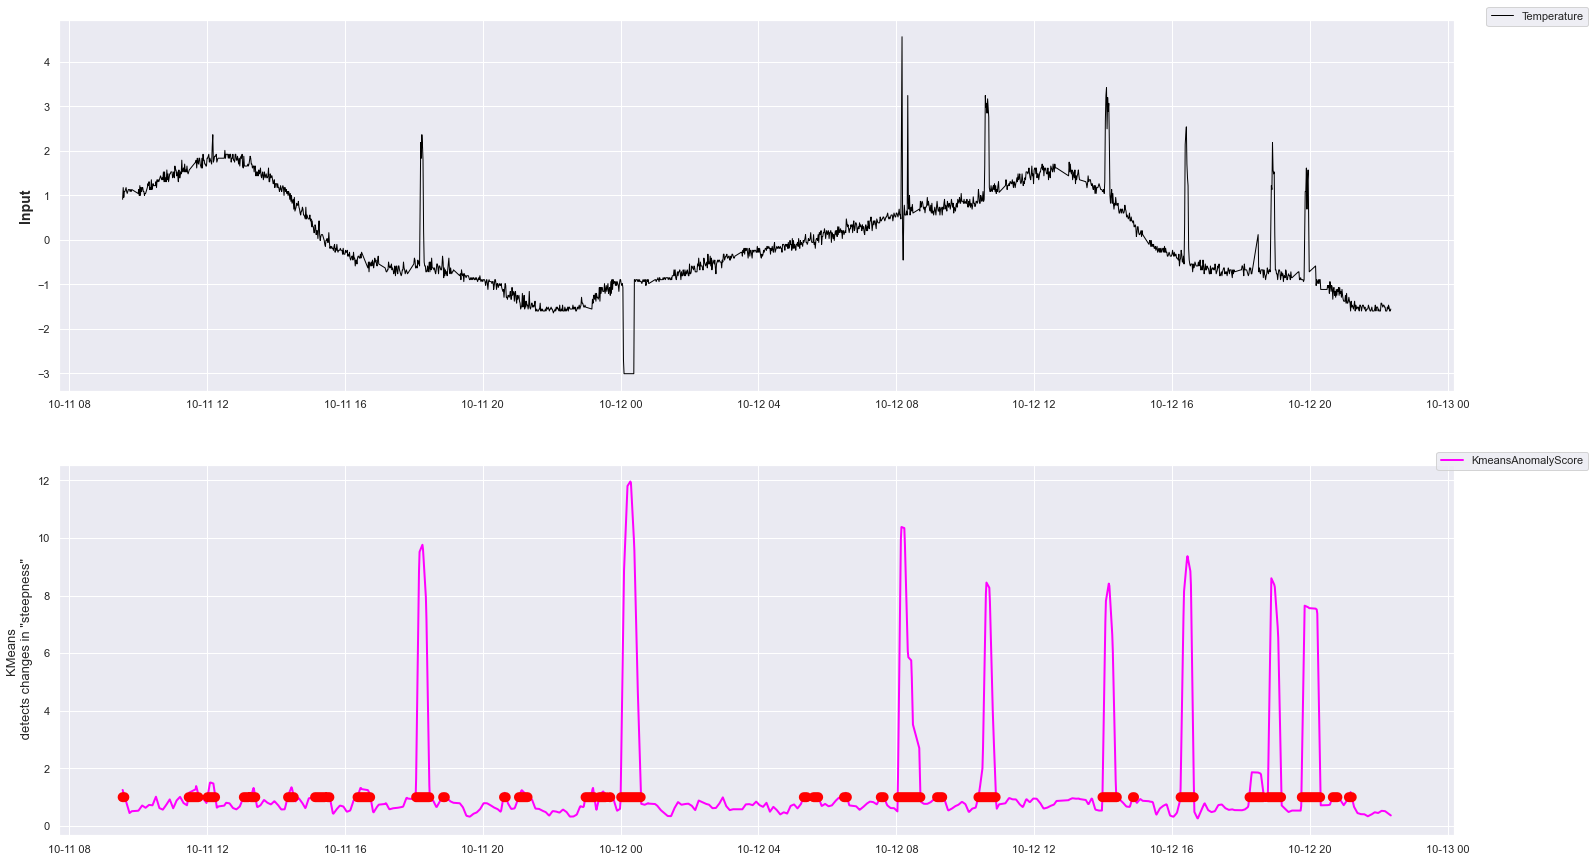

In [7]:
# Simplify dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)
df_anomaly_val = em.run_kmeans(df_val, nclusters=40)
df_plot = df_anomaly_val.loc[[entity]]
df_plot.reset_index(level=[0], inplace=True)
em.visualize_kmeans(df_plot, threshold=0.43)

**Changing contamination**

In [8]:
#add number of cluster as option
df_anomaly = em.run_kmeans(df_val, nclusters=40, contamination=0.07)
df_anomaly.describe()

2020-08-20T09:37:49.722 WARNING iotfunctions.metadata.__init__ No _db_schema specified in **kwargs. Usingdefault database schema.
2020-08-20T09:37:49.723 WARNING iotfunctions.metadata.__init__ Created a logical entity type. It is not connected to a real database table, so it cannot perform any database operations.
2020-08-20T09:37:49.941 INFO src.anomalymodels.anomaly.execute For entity MyRoom CBLOF threshold: 2.524008851978162


,Temperature,KmeansAnomalyScore
count,1999.000000,1999.000000
mean,-0.008489,0.578936
std,1.090662,0.870794
min,-3.010018,0.130857
25%,-0.807152,0.253646
50%,-0.234407,0.314954
75%,0.867026,0.404749
max,4.567841,5.157376


kmeans anomaly threshold: 2.536


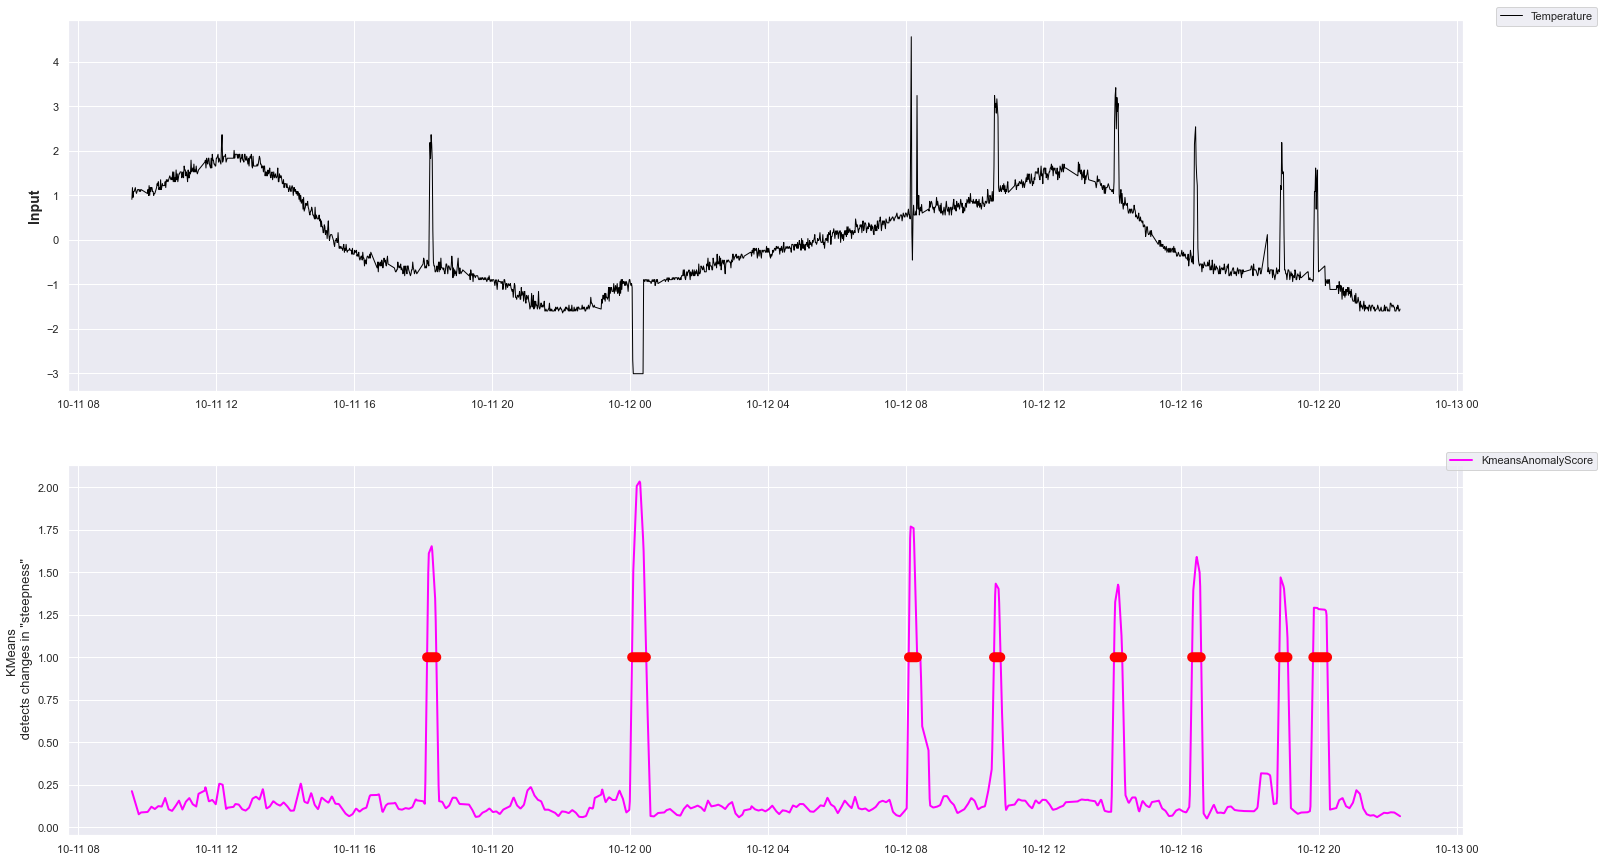

In [9]:
# Simplify dataframe to prepare input for plotting
EngineLogging.configure_console_logging(logging.INFO)
df_plot = df_anomaly.loc[[entity]]
df_plot.reset_index(level=[0], inplace=True)
em.visualize_kmeans(df_plot, threshold=2.536)

In [23]:
import json
df = pd.DataFrame({"name": ['Superman', 'Batman', 'Spiderman'],
                   "toy": [np.nan, 'Batmobile', 'Spiderman toy'],
                   "born": [np.nan, 0,
                            np.nan]})
df

,name,toy,born
0,Superman,NaN,NaN
1,Batman,Batmobile,0.0
2,Spiderman,Spiderman toy,NaN


In [76]:
def f1(df):
    # first convert to a sparse dictionary 
    sparsedict = [row.dropna().to_dict() for index, row in df.iterrows()]
    # then convert to JSON
    return json.dumps(sparsedict)[1:-1]

f1(df)

'{"name": "Superman"}, {"name": "Batman", "toy": "Batmobile", "born": 0.0}, {"name": "Spiderman", "toy": "Spiderman toy"}'

In [50]:
def f2(df):
    return df.to_json(orient='records')

f2(df)

'[{"name":"Superman","toy":null,"born":null},{"name":"Batman","toy":"Batmobile","born":0.0},{"name":"Spiderman","toy":"Spiderman toy","born":null}]'

In [56]:
def f3(df):
    return df.apply(lambda x: x.dropna(), axis=1)

f3(df)

,born,name,toy
0,NaN,Superman,NaN
1,0.0,Batman,Batmobile
2,NaN,Spiderman,Spiderman toy


In [69]:
def f4(df):
    return df.T.apply(lambda row: row[~row.isnull()].to_dict()).to_json(orient='records')
    json_df = df.T.apply(lambda row: row[~row.isnull()].to_json())
    json_wrapped = "[%s]" % ",".join(json_df)
    return json_wrapped

f4(df)

'[{"name":"Superman"},{"name":"Batman","toy":"Batmobile","born":0.0},{"name":"Spiderman","toy":"Spiderman toy"}]'

In [72]:
def f5(df):
    return [{**x[i]} for i, x in df.stack().groupby(level=0)]

f5(df)

[{'name': 'Superman'},
 {'name': 'Batman', 'toy': 'Batmobile', 'born': 0.0},
 {'name': 'Spiderman', 'toy': 'Spiderman toy'}]

In [74]:
def f6(df):
    return [dict(zip(x.index.get_level_values(1),x)) for _,x in df.replace('NAN',np.nan).stack().groupby(level=0)]
    
f6(df)

[{'name': 'Superman'},
 {'name': 'Batman', 'toy': 'Batmobile', 'born': 0.0},
 {'name': 'Spiderman', 'toy': 'Spiderman toy'}]